# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   7951      0 --:--:-- --:--:-- --:--:--  9418


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
# import the libraries
import gym
import random
import torch
import numpy as np
import time
import torch
import matplotlib.pyplot as plt

from maddpg_agent import Agent
from collections import deque
from unityagents import UnityEnvironment

%matplotlib inline

In [9]:
# initiate the agents
agent_0 = Agent(state_size=state_size, action_size=action_size, num_agents = 1, random_seed = 0)
agent_1 = Agent(state_size=state_size, action_size=action_size, num_agents = 1, random_seed = 0)

In [10]:
# MADDPG function

def maddpg(n_episodes=25000, max_t=10000, print_every=1):
    """Multi-Agent Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    max_scores = []                               # list of mean scores from each episode
    moving_avgs = []                               # list of moving averages
    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes
    best_score = -np.inf
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        #states = env_info.vector_observations
        states = np.reshape(env_info.vector_observations, (1, state_size * 2))
        
        scores = np.zeros(num_agents)                           # initialize score for each agent
        
        agent_0.reset()
        agent_1.reset()
        
        start_time = time.time()
        while True: #for t in range(max_t):
            actions_0 = agent_0.act(states, add_noise=True)         # select an action
            actions_1 = agent_1.act(states, add_noise=True)
            actions = np.concatenate((actions_0, actions_1), axis=0).flatten()
            
            env_info = env.step(actions)[brain_name]            # send actions to environment
            #next_states = env_info.vector_observations         # get next state
            next_states = np.reshape(env_info.vector_observations, (1, state_size * 2))
            
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent_0.step(states, actions, rewards[0], next_states, dones, 0)
            agent_1.step(states, actions, rewards[1], next_states, dones, 1)
            
            states = next_states
            scores += np.max(rewards)        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        max_score = np.max(scores)
        max_scores.append(max_score)           # save max score for the episode
        scores_window.append(max_score)         # save max score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
        
        if max_score > best_score:
            best_score = max_score
            
        if i_episode % print_every == 0:
            print('\rEpisode {} ({}s)\tMoving Avg: {:.4f}\tBest Score: {:.4f}'.format(\
                  i_episode, round(duration), moving_avgs[-1], best_score))
                  
        if moving_avgs[-1] >= 0.5 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avgs[-1]))  
            torch.save(agent_0.actor_local.state_dict(), 'actor_0_final_checkpoint.pth')
            torch.save(agent_0.critic_local.state_dict(), 'critic_0_final_checkpoint.pth')
            torch.save(agent_1.actor_local.state_dict(), 'actor_1_final_checkpoint.pth')
            torch.save(agent_1.critic_local.state_dict(), 'critic_1_final_checkpoint.pth')
            break
            
    return max_scores, moving_avgs

In [11]:
start = time.time()

In [12]:
from workspace_utils import active_session

with active_session():
    scores, avgs = maddpg()

Episode 1 (0s)	Moving Avg: 0.1000	Best Score: 0.1000
Episode 2 (0s)	Moving Avg: 0.0500	Best Score: 0.1000
Episode 3 (0s)	Moving Avg: 0.0333	Best Score: 0.1000
Episode 4 (0s)	Moving Avg: 0.0250	Best Score: 0.1000
Episode 5 (0s)	Moving Avg: 0.0200	Best Score: 0.1000
Episode 6 (0s)	Moving Avg: 0.0167	Best Score: 0.1000
Episode 7 (0s)	Moving Avg: 0.0143	Best Score: 0.1000
Episode 8 (0s)	Moving Avg: 0.0125	Best Score: 0.1000
Episode 9 (0s)	Moving Avg: 0.0111	Best Score: 0.1000
Episode 10 (0s)	Moving Avg: 0.0100	Best Score: 0.1000
Episode 11 (0s)	Moving Avg: 0.0091	Best Score: 0.1000
Episode 12 (0s)	Moving Avg: 0.0083	Best Score: 0.1000
Episode 13 (0s)	Moving Avg: 0.0077	Best Score: 0.1000
Episode 14 (0s)	Moving Avg: 0.0071	Best Score: 0.1000
Episode 15 (0s)	Moving Avg: 0.0067	Best Score: 0.1000
Episode 16 (0s)	Moving Avg: 0.0063	Best Score: 0.1000
Episode 17 (0s)	Moving Avg: 0.0059	Best Score: 0.1000
Episode 18 (0s)	Moving Avg: 0.0056	Best Score: 0.1000
Episode 19 (0s)	Moving Avg: 0.0053	Be

In [13]:
end = time.time()
elapsed = (end - start) / 60.0 # in minutes
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))


Elapsed Time: 85.31 mins.


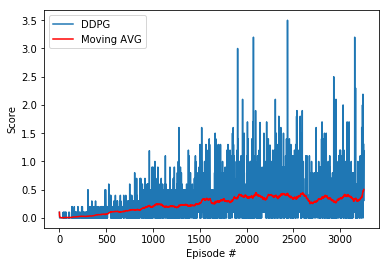

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [15]:
env.close()